In [2]:
# python 3.7
# based on Zhang, L. implementation
# paper: https://arxiv.org/abs/0802.4411

%matplotlib notebook
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt

from matplotlib           import cm
from mpl_toolkits.mplot3d import axes3d

plt.style.use('seaborn')

def Heston_Calls(series):
    # Variables
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho   = series['rho'] # Correlation
    v0    = series['Cv0'] # Initial Variance (I use Call Implied Variance from BSM instead)
    T     = series['T'] # Time to maturity
    s0    = series['s0'] # Spot Price
    K     = series['K'] # Strike Price
    N     = 10000 # Nº of simulations
    dt    = 1/32 # Timestep granularity (related to the nº of steps being generated)

    # Calculations
    vega  =(4*kappa*theta/(sigma*sigma))
    K1    = dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2    = dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3    = dt*(1-rho*rho)/2
    ss    = K2+K3/2
    yita  = 4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh    = ss*np.exp(-kappa*dt)/yita
    S     = np.ones(N)*s0
    v     = np.ones(N)*v0
    Ntime=int(T/dt)
    
    # Simulations
    for i in range (0,Ntime):
        Zs   = np.random.randn(1,N)
        lamb = v*yita
        W    = np.random.noncentral_chisquare(vega,lamb)
        v2   = W*np.exp(-kappa*dt)/yita
        K0   = -lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S    = S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
        v    = v2
    payoff=np.maximum(S-K,0)
    return np.mean(payoff)

def Heston_Puts(series):
    # Variables
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho   = series['rho'] # Correlation
    v0    = series['Pv0'] # Initial Variance (I use Put Implied Variance from BSM instead)
    T     = series['T'] # Time to maturity
    s0    = series['s0'] # Spot Price
    K     = series['K'] # Strike Price
    N     = 10000 # Nº of simulations
    dt    = 1/32 # Timestep granularity (related to the nº of steps being generated)

    # Calculations
    vega  = (4*kappa*theta/(sigma*sigma))
    K1    = dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2    = dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3    = dt*(1-rho*rho)/2
    ss    = K2+K3/2
    yita  = 4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh    = ss*np.exp(-kappa*dt)/yita
    S     = np.ones(N)*s0
    v     = np.ones(N)*v0
    Ntime = int(T/dt)

    # Simulations
    for i in range (0,Ntime):
        Zs   = np.random.randn(1,N)
        lamb = v*yita
        W    = np.random.noncentral_chisquare(vega,lamb)
        v2   = W*np.exp(-kappa*dt)/yita
        K0   = -lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S    = S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
        v    = v2
    payoff=np.maximum(K-S,0)
    return np.mean(payoff)

db             = pd.read_hdf("optiondata.h5")
db['Now']      = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [3]:
HTest = pd.DataFrame({'T': db['Expiration'],'Cv0': db['CallImpVol']**2, 'Now': db['Now'],
                     's0': db['Spot'],'Pv0': db['PutImpVol']**2,'Put': db['PutMid'],
                     'K': db['Strike'],'Call': db['CallMid'],'Maturity': db['Maturity']})

HTest[HTest['Cv0'] < 0.001] = 0
HTest[HTest['Pv0'] < 0.001] = 0
HTest = HTest.loc[(HTest!=0).any(1)]
HTest = HTest.reset_index().drop('index',axis=1)

# Calibration can still be improved
HTest['Moneyness'] = abs(HTest['K']/HTest['s0'])
HTest['theta'] = 0.0722
HTest['kappa'] = 0.4816
HTest['sigma'] = 0.621
HTest['rho']   = -0.5527

In [4]:
HTest['Heston Call'] = round(HTest.apply(Heston_Calls, axis=1),2)
HTest['CError'] = abs(HTest['Heston Call']/HTest['Call']-1)
HTest['CError'].describe()

count    429.000000
mean       0.177740
std        0.161867
min        0.000000
25%        0.080398
50%        0.151679
75%        0.192312
max        0.865672
Name: CError, dtype: float64

In [5]:
HTest['Heston Put'] = round(HTest.apply(Heston_Puts, axis=1),2)
HTest['PError'] = abs(HTest['Heston Put']/HTest['Put']-1)
HTest['PError'].describe()

count    429.000000
mean       0.094510
std        0.041814
min        0.001626
25%        0.062764
50%        0.100968
75%        0.129030
max        0.191632
Name: PError, dtype: float64

In [6]:
HTest.groupby('Maturity')['CError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,0.438470,0.273691,0.005472,0.198657,0.471899,0.677168,0.828571
2018-06-15 17:30:00,62.0,0.166096,0.099598,0.000000,0.082457,0.192557,0.225464,0.536842
2018-09-21 17:30:00,105.0,0.152353,0.151830,0.006869,0.072828,0.131065,0.153472,0.865672
2018-12-21 17:30:00,125.0,0.140231,0.134649,0.001727,0.046330,0.133546,0.177397,0.712613
2019-03-15 17:30:00,98.0,0.156391,0.041732,0.033057,0.133667,0.168231,0.185231,0.213400


In [7]:
HTest.groupby('Maturity')['PError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,0.135687,0.034622,0.069141,0.112662,0.142721,0.163747,0.191632
2018-06-15 17:30:00,62.0,0.061952,0.016696,0.025139,0.053415,0.060938,0.069558,0.101441
2018-09-21 17:30:00,105.0,0.099591,0.035036,0.005104,0.080023,0.103981,0.127340,0.167726
2018-12-21 17:30:00,125.0,0.102801,0.042300,0.001626,0.086857,0.120180,0.134369,0.162980
2019-03-15 17:30:00,98.0,0.082705,0.043009,0.003292,0.050600,0.094533,0.115902,0.165029


<IPython.core.display.Javascript object>


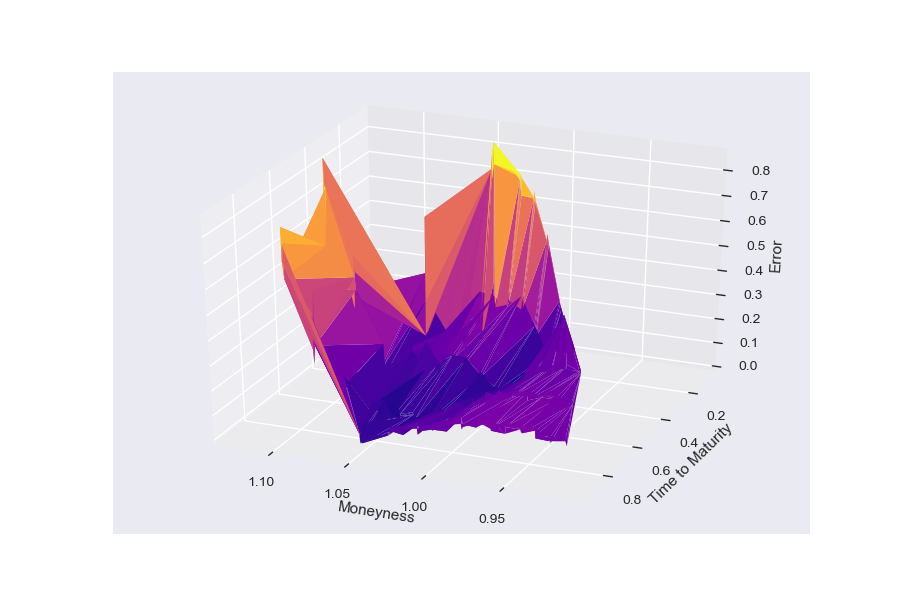

In [8]:
fig = plt.figure(figsize=(9,6))
ax  = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['CError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()

<IPython.core.display.Javascript object>


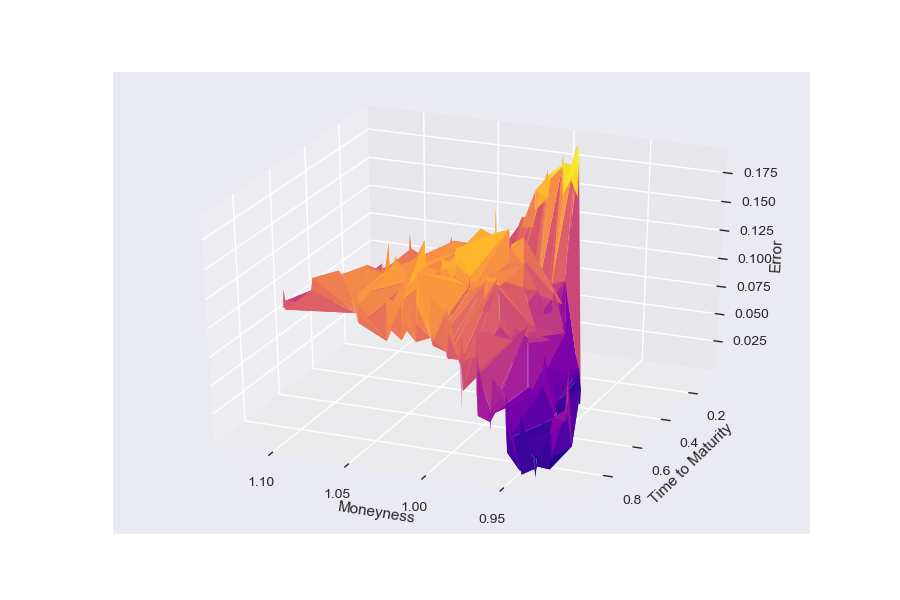

In [9]:
fig = plt.figure(figsize=(9,6))
ax  = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['PError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()